In [ ]:
!pip install networkx gensim torch torch-geometric

In [ ]:
import networkx as nx
import pandas as pd
import torch

In [ ]:
edges = pd.read_csv('cora.cites', sep='\t', header=None, names=['source', 'target'])
nodes = pd.read_csv('cora.content', sep='\t', header=None)

In [ ]:
all_nodes = pd.concat([edges['source'], edges['target']]).unique()

node_mapping = {node_id: idx for idx, node_id in enumerate(all_nodes)}

edges['source'] = edges['source'].map(node_mapping)
edges['target'] = edges['target'].map(node_mapping)

In [ ]:
G = nx.from_pandas_edgelist(edges, 'source', 'target')

In [ ]:
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

features = torch.tensor(nodes.iloc[:, 1:-1].values, dtype=torch.float)
labels = LabelEncoder().fit_transform(nodes.iloc[:, -1])
labels = torch.tensor(labels, dtype=torch.long)

edge_index = torch.tensor(list(map(list, zip(*G.edges))), dtype=torch.long)

data = Data(x=features, edge_index=edge_index, y=labels)

In [ ]:
print(data.edge_index)
print(data.edge_index.shape)

tensor([[   0,    0,    0,  ..., 1559, 1563, 1563],
        [  20,  814,  815,  ..., 1560, 1560, 1562]])
torch.Size([2, 5278])


In [ ]:
print(features.shape)

torch.Size([2708, 1433])


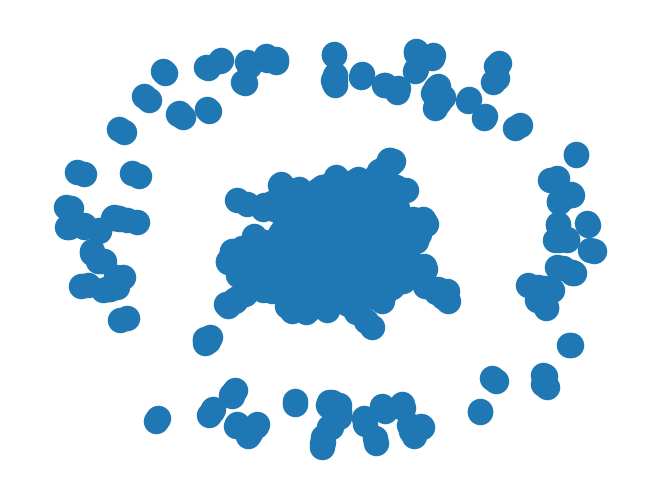

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
nx.draw(G, with_labels=False)

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [ ]:
import torch.nn.functional as F

model = GCN(num_features=data.num_features, hidden_channels=16, num_classes=len(np.unique(data.y.numpy())))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model(data.x, data.edge_index)
    loss = F.cross_entropy(z, data.y)
    loss.backward()
    optimizer.step()
    return loss, z

losses = []

for epoch in range(200):
    loss, z = train()
    losses.append(loss.item())

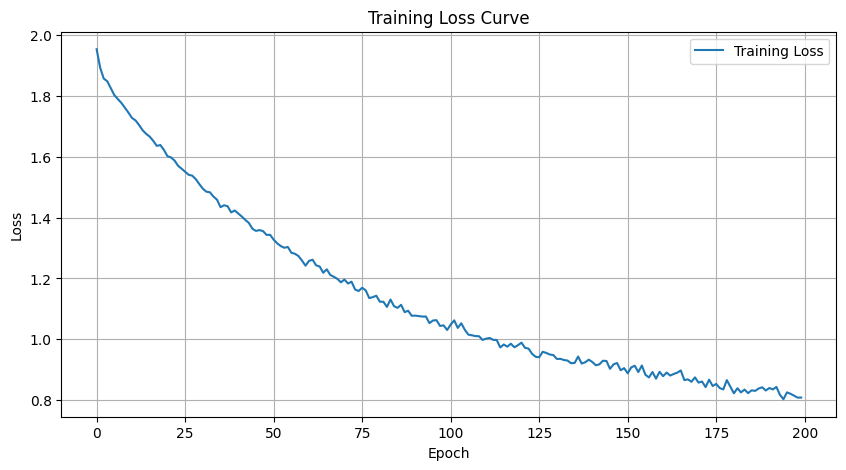

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
G = to_networkx(data, to_undirected=True)

def calculate_modularity(G, labels):
    communities = {node: int(label) for node, label in enumerate(labels)}

    from collections import defaultdict
    community_dict = defaultdict(set)
    for node, comm in communities.items():
        community_dict[comm].add(node)

    return nx.algorithms.community.modularity(G, community_dict.values())

In [ ]:
from sklearn.cluster import KMeans

best_score = -float('inf')
best_k = 0

z_np = z.detach().numpy()

for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(z_np)
    clusters = kmeans.labels_

    modularity_score = calculate_modularity(G, clusters)

    if modularity_score > best_score:
        best_score = modularity_score
        best_k = k
        best_clusters = clusters
    print(f'{k}: Modularity Score = {modularity_score}')

kmeans = KMeans(n_clusters=best_k, random_state=0).fit(z_np)
clusters = kmeans.labels_

print(f'Best k: {best_k} with modularity score: {best_score}')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


1: Modularity Score = 0.0
2: Modularity Score = 0.05561583103363557


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3: Modularity Score = 0.05448221370037369


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


4: Modularity Score = 0.04549163873979961


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


5: Modularity Score = 0.042092850832119874


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


6: Modularity Score = 0.04199880002659269


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


7: Modularity Score = 0.052371885931162564


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


8: Modularity Score = 0.062140085156901864


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


9: Modularity Score = 0.06465755958118533


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


10: Modularity Score = 0.06122847439111438


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


11: Modularity Score = 0.0633237432622649


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


12: Modularity Score = 0.07074873128335124


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


13: Modularity Score = 0.06897192490122153


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


14: Modularity Score = 0.06327838708181314


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


15: Modularity Score = 0.0642379206817147


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


16: Modularity Score = 0.060662051619964096


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


17: Modularity Score = 0.06602061421350337


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


18: Modularity Score = 0.06060057757245824


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


19: Modularity Score = 0.06404141911322007


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


20: Modularity Score = 0.05831569940558455


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


21: Modularity Score = 0.06450273472460559


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


22: Modularity Score = 0.06341766842740305


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


23: Modularity Score = 0.06120693603870355


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


24: Modularity Score = 0.056276591788345195


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


25: Modularity Score = 0.060438304035669806


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


26: Modularity Score = 0.05604311604821202


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


27: Modularity Score = 0.06078117665742288


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


28: Modularity Score = 0.05616557953029448


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


29: Modularity Score = 0.05358191056960183


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Best k: 12 with modularity score: 0.07074873128335124


In [ ]:
def test():
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index)
        predictions = logits.max(1)[1]
    return predictions

predictions = test()

In [ ]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

true_labels = data.y.numpy()
predicted_labels = predictions.numpy()

nmi_score = normalized_mutual_info_score(true_labels, predicted_labels)
ari_score = adjusted_rand_score(true_labels, predicted_labels)

print(f'Normalized Mutual Information (NMI): {nmi_score:.4f}')
print(f'Adjusted Rand Index (ARI): {ari_score:.4f}')

Normalized Mutual Information (NMI): 0.6778
Adjusted Rand Index (ARI): 0.6956


In [ ]:
import networkx as nx

G = nx.Graph()
edge_list = data.edge_index.t().numpy()
G.add_edges_from(edge_list)

communities = {node: int(pred) for node, pred in enumerate(predicted_labels)}

from networkx.algorithms.community import modularity

partition = {}
for node, comm in communities.items():
    if comm not in partition:
        partition[comm] = [node]
    else:
        partition[comm].append(node)

modularity_score = modularity(G, partition.values())
print(f'Modularity: {modularity_score:.4f}')

Modularity: 0.0848
